BEV

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from nuscenes.nuscenes import NuScenes
from pyquaternion import Quaternion

In [11]:
nusc = NuScenes(version='v1.0-mini', dataroot='F:/Project/nuscenes-devkit/v1.0-mini', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.289 seconds.
Reverse indexing ...
Done reverse indexing in 0.0 seconds.


In [12]:
def create_bev_view(sample_index=0, cam_channel='CAM_FRONT', bev_width=40, bev_length=40, resolution=0.04):
    """
    Create bev view
    
    Args:
    - sample_index: sample index
    - cam_channel: camera channel
    - bev_width: bev view width (meters)
    - bev_length: bev view length (meters)
    - resolution: resolution, the actual distance per pixel (meters/pixel)
    
    Returns:
    - bird_eye_view: bev view image
    - img: original image
    """
    # Read sample data
    sample = nusc.sample[sample_index]
    cam_token = sample['data'][cam_channel]
    cam_data = nusc.get('sample_data', cam_token)
    cs_record = nusc.get('calibrated_sensor', cam_data['calibrated_sensor_token'])
    K = np.array(cs_record['camera_intrinsic']) # Camera intrinsic matrix
    img_path = nusc.get_sample_data_path(cam_token)
    print("="*40)
    
    # Read image
    print(f"Read image: {img_path}")
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGBA)
    img_height, img_width = img.shape[:2]
    
    # Camera
    cs_record = nusc.get('calibrated_sensor', cam_data['calibrated_sensor_token'])
    cam_to_ego_rotation = Quaternion(cs_record['rotation']).rotation_matrix
    cam_to_ego_translation = np.array(cs_record['translation'])
    
    # Camera coordinate to ego coordinate
    cam_to_ego = np.eye(4)
    cam_to_ego[:3, :3] = cam_to_ego_rotation
    cam_to_ego[:3, 3] = cam_to_ego_translation
    
    # Camera position in ego
    cam_pos_ego = cam_to_ego_translation
    
    # Size
    bev_height = int(bev_length / resolution)
    bev_width_pixels = int(bev_width / resolution)
    
    # Create transparent bev view and weight map
    bird_eye_view = np.zeros((bev_height, bev_width_pixels, 4), dtype=np.uint8)
    weight_map = np.zeros((bev_height, bev_width_pixels), dtype=np.float32)
    print(f"Image size: {img_width} x {img_height}")
    print(f"Top view size: {bev_width_pixels} x {bev_height}")
    
    # Vehicle center position
    ego_center_x = bev_width_pixels // 2
    ego_center_y = bev_height // 2
    
    base_step = 1
    mapped_pixels = 0
    
    # Iterate over all pixels
    for v in range(0, img_height, base_step):
        for u in range(0, img_width, base_step):
            # 使用相机内参将像素坐标转换为归一化坐标
            x_norm = (u - K[0, 2]) / K[0, 0]
            y_norm = (v - K[1, 2]) / K[1, 1]
            
            # 相机坐标系中的射线方向
            ray_camera = np.array([x_norm, y_norm, 1.0])
            
            # 将射线方向转换到车辆坐标系
            ray_ego = cam_to_ego[:3, :3] @ ray_camera
            ray_ego = ray_ego / np.linalg.norm(ray_ego)
            
            # 如果射线向上或几乎平行于地面，则不会与地面相交
            if ray_ego[2] >= -0.1:
                continue
            
            # 计算射线与地面(Z=0平面)的交点（在车辆坐标系中）
            t = -cam_pos_ego[2] / ray_ego[2]
            ground_point_ego = cam_pos_ego + t * ray_ego
            
            # 提取车辆坐标系中的x,y坐标
            x_ego, y_ego = ground_point_ego[0], ground_point_ego[1]
            
            # 在车辆坐标系中的过滤条件
            half_length = bev_length / 2
            half_width = bev_width / 2
            
            # 使用车辆为中心的坐标过滤：确保点在BEV范围内
            if x_ego < -half_length or x_ego > half_length:
                continue
                
            if y_ego < -half_width or y_ego > half_width:
                continue
            
            # 计算到车辆中心的距离，用于权重计算
            distance = np.sqrt(x_ego**2 + y_ego**2)
            weight = np.exp(-distance / 20.0)
            
            # 将车辆坐标系中的点映射到BEV图像坐标（水平镜像）
            i = ego_center_y - int(x_ego / resolution)    # x_ego正值（前方）对应图像上半部分
            j = ego_center_x - int(y_ego / resolution)    # y_ego正值（左方）对应图像左半部分
            
            # 确保坐标在图像范围内
            if 0 <= i < bev_height and 0 <= j < bev_width_pixels:
                # 基于权重选择像素
                if weight > weight_map[i, j]:
                    bird_eye_view[i, j] = img[v, u]
                    bird_eye_view[i, j, 3] = 255  # 设置不透明度
                    weight_map[i, j] = weight
                    mapped_pixels += 1
    
    print(f"\nSuccessfully mapped pixels: {mapped_pixels}")
    
    # bird_eye_view = smooth_bev_image(bird_eye_view, resolution)
    
    return bird_eye_view, img

In [13]:
def smooth_bev_image(image, resolution=0.04):
    """
    Apply smoothing operations to the BEV image
    
    Args:
    - image: BEV image to smooth
    - resolution: resolution in meters/pixel
    
    Returns:
    - smoothed_image: processed image
    """
        
    # Create adaptive kernel size based on resolution
    kernel_size = max(3, int(5 * resolution / 0.1))
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    
    # Process RGB and alpha channels separately
    rgb_channels = image[:, :, :3]
    alpha_channel = image[:, :, 3]
    
    # Apply morphological closing operation
    rgb_channels = cv2.morphologyEx(rgb_channels, cv2.MORPH_CLOSE, kernel)
    alpha_channel = cv2.morphologyEx(alpha_channel, cv2.MORPH_CLOSE, kernel)
    
    # Apply Gaussian blur
    blur_size = max(3, int(3 * resolution / 0.1))
    if blur_size % 2 == 0:
        blur_size += 1
    rgb_channels = cv2.GaussianBlur(rgb_channels, (blur_size, blur_size), 0)
    alpha_channel = cv2.GaussianBlur(alpha_channel, (blur_size, blur_size), 0)
    
    # Recombine channels
    smoothed_image = np.dstack((rgb_channels, alpha_channel))
    
    return smoothed_image

In [14]:
def visualize_bev_view(bird_eye_view, original_img, save_flag=False):
    """
    Visualize the bev view transformation result
    
    Args:
    - sample_index: sample index
    - cam_channel: camera channel
    """
    
    # Visualize
    plt.figure(figsize=(15, 8))
    
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(original_img)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title('Projection Image')
    plt.imshow(bird_eye_view)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    if save_flag:
        plt.figure(figsize=(10, 10))
        plt.title('Top View')
        plt.imshow(bird_eye_view)
        plt.axis('off')
        plt.savefig('bird_eye_view_only.png', transparent=True)

Read image: F:/Project/nuscenes-devkit/v1.0-mini\samples/CAM_FRONT/n008-2018-08-01-15-16-36-0400__CAM_FRONT__1533151618912404.jpg
Image size: 1600 x 900
Top view size: 1000 x 1000

Successfully mapped pixels: 285538


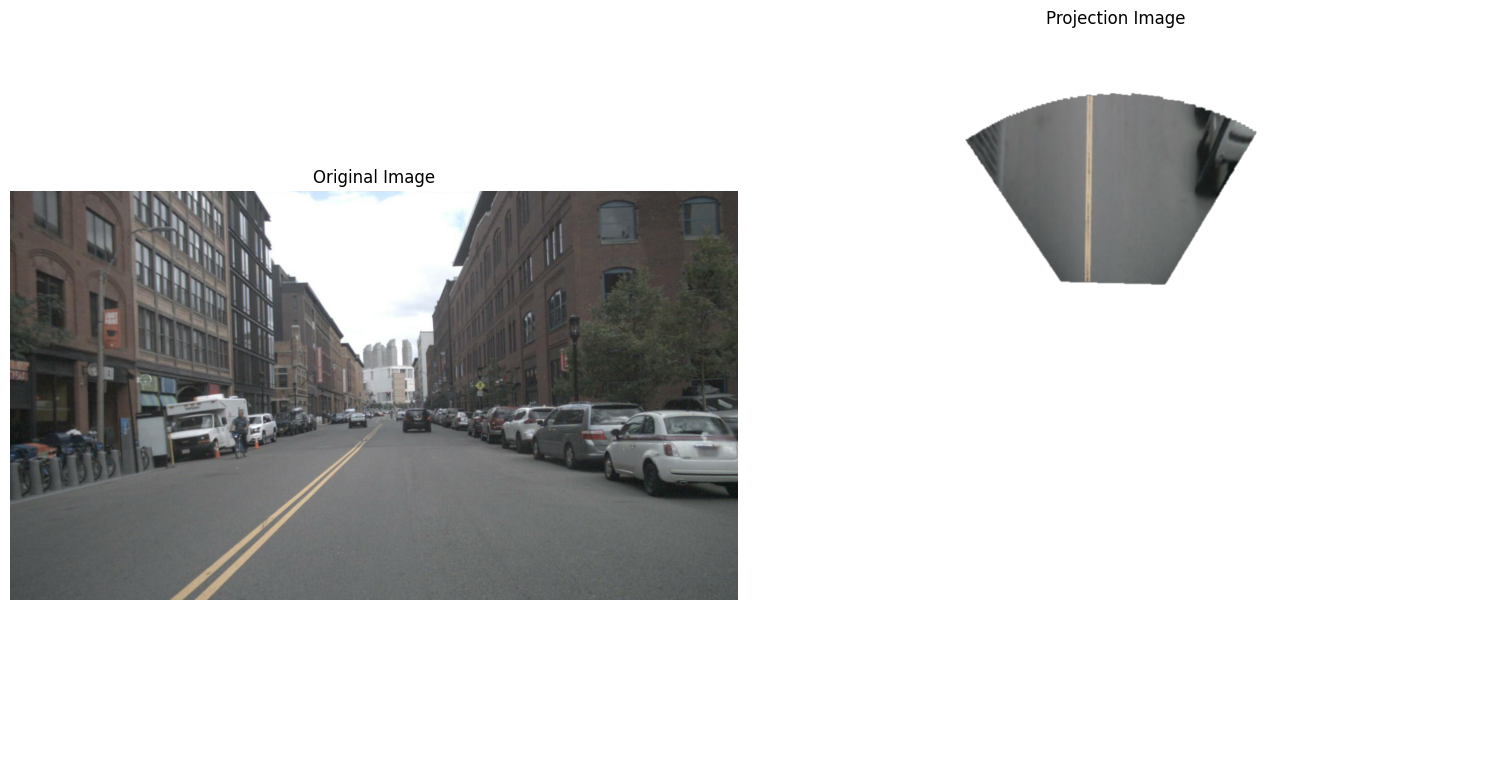

In [15]:
bird_eye_view, img = create_bev_view(sample_index=70, cam_channel='CAM_FRONT', bev_width=40, bev_length=40, resolution=0.04)
bird_eye_view = smooth_bev_image(bird_eye_view, resolution=0.04)
visualize_bev_view(bird_eye_view=bird_eye_view, original_img=img, save_flag=False)